# Assignment #2

Abhilash Vikram Gupta, Hao Lun Chu Colin, Matthew Viteri, Stephen Oluwaniyi and Yeggi Lee

In [61]:
import numpy as np
import pandas as pd
import tweepy
import GetOldTweets3 as got
import re
import textblob
import nltk
import matplotlib.pyplot as plt
import random

from sklearn import manifold
from configparser import ConfigParser
from IPython.display import display
from collections import Counter
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

stop_words = set(stopwords.words('english'))

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/matt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### A. Collect 5k tweets on the 2020 Presidential election. It is necessary to use general hashtags and search keywords (like 2020 U.S. election or 2020 Presidential Election) rather than “Trump” or “Biden” or “Warren”. Use Tweepy in your Python script, and also ask for the location specified by the user during registration with Twitter. 

In [2]:
def get_creds():
    config = ConfigParser()
    config.read('./credentials.ini')

    consumer_section = config['consumer']
    api_key, api_secret_key = consumer_section['api-key'], consumer_section['api-secret-key']

    access_section = config['access']
    access_token, access_token_secret = access_section['access-token'], access_section['access-token-secret']
    
    return api_key, api_secret_key, access_token, access_token_secret

try:
    consumer_key, consumer_secret, access_token, access_token_secret = get_creds()
except KeyError as e:
    raise IOError('Twitter credentials used are not included as part of the submitted assignment.' +
                 ' We have a csv with the collected data.') from e

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
display('Preparing...')
df = pd.DataFrame(columns=['Date', 'Username', 'User Location', 'Tweet'])

query = 'president election 2020'
start = '2019-01-01'
end = '2019-09-01'
count = 5000
tweetCriteria = (got.manager.TweetCriteria()
                 .setQuerySearch(query)
                 .setSince(start)
                 .setUntil(end)
                 .setMaxTweets(count))

display('Collecting tweets...')
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

display('Creating dataframe...')
for tweet in tweets:
    df = df.append({
        'Date': tweet.date,
        'Username': tweet.username,
        'Tweet': tweet.text
    }, ignore_index=True)

display('Collecting user locations...')
for index, row in df.iterrows():
    if pd.isna(row['User Location']):
        df.at[index, 'User Location'] = api.get_user(row['Username']).location

display('Done.')
display(df)
df.to_csv(f'./{query}_({count})_{end}.csv', index=False)

### B.   Find FOUR key issues mentioned by the public in the tweets – e.g., character, personality, healthcare, crime, jobs, etc. (these are examples only, use wordfrequency analysis to find out). Replace words if necessary. Issues associated with Mr. Trump may not have a strong association with the democratic candidate and vice versa. So find a couple of issues that are likely to have strong association with Mr. Trump, and a couple for the democratic candidate.

In [62]:
df = pd.read_csv('president election 2020_(5000)_2019-09-01.csv', index_col=0)

In [63]:
same_map = {
    'trump':      ['donald', '@realdonaldtrump', 'maga', '#maga', 'trump’s', "trump's", '#trump',
                   'maga2020', '#maga2020', '#kag2020', '#kag', 'kag', 'kag2020', '#trump2020',''],
    'warren':     ['elizabeth', '@ewarren', 'elizabethwarren', '@senwarren', '#elizabethwarren'],
    'biden':      ['joe', '@joebiden', "biden's"],
    'russia':     ['russian', 'putin'],
    'republican': ['gop'],
    'musk':       ['elon']
}

same_inv_map = {word: root for root, words in same_map.items() for word in words}

def splitter(data):
    words = re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", data.lower()).split()
    return [textblob.Word(word).lemmatize() for word in words]

def convert_same(text):
    return [(same_inv_map[word] if word in same_inv_map else word) for word in splitter(text)]

def wordCount(data):
    filtered = [w for w in convert_same(' '.join(data['Tweet'])) if w not in stop_words]
    return Counter(filtered).most_common(400)

df['Split Tweet'] = df['Tweet'].map(convert_same)

wordCount(df)[:50]

[('president', 5221),
 ('election', 5125),
 ('2020', 5050),
 ('trump', 4461),
 ('win', 655),
 ('ha', 649),
 ('u', 586),
 ('vote', 571),
 ('democrat', 515),
 ('get', 462),
 ('presidential', 461),
 ('going', 412),
 ('would', 403),
 ('people', 377),
 ('american', 375),
 ('former', 374),
 ('america', 366),
 ('republican', 363),
 ('state', 359),
 ('voter', 338),
 ('say', 330),
 ('new', 326),
 ('like', 314),
 ('wa', 303),
 ('need', 299),
 ('want', 296),
 ('one', 289),
 ('biden', 286),
 ('2016', 285),
 ('year', 272),
 ('know', 271),
 ('day', 271),
 ('time', 270),
 ('democratic', 258),
 ('russia', 256),
 ('make', 255),
 ('mr', 251),
 ('next', 249),
 ('think', 226),
 ('country', 224),
 ('fed', 224),
 ('candidate', 202),
 ('economy', 193),
 ('via', 192),
 ('lose', 187),
 ('recession', 187),
 ('great', 185),
 ('way', 182),
 ('poll', 178),
 ('keep', 177)]

#### 4 KEY ISSUES
- economy/recession 193/187
- Russia 256
- war 91
- pro-life 92
- fake 104
- racist 84
- fraud 70
- strong 75
- hate 76
- impeachment 63

#### Same words
- donald, trump, @realdonaldtrump, maga, kag <-- make america great gain
- joe, biden, @joebiden, biden's
- elizabeth, warren, @ewarren, elizabethwarren, #elizabethwarren, @senwarren
- michael, steele
- russia, russian, putin
- president, presidents
- republicans, republican, gop
- bernie, sanders

#### NOTES
- mike, pence --> running mate of Trump 
- kag --> keep america great



### C. Perform lift and sentiment analysis on a candidate and an issue. To isolate a candidate and an issue, you have to write a parser that selects tweets that mention a candidate, takes a window around an issue, and chops off everything else, as shown in class.

In [64]:
key_issues = ["economy", "recession", "russia", "war", "fake"]
key_issues_df = pd.DataFrame(columns=key_issues)
print(key_issues_df)

Empty DataFrame
Columns: [economy, recession, russia, war, fake]
Index: []


In [65]:
#Find issues that were mentioned in each post. If an issue exists in a post return 1, else return 0
def issue_mentioned(item):
    if issue in item:
        return 1
    else:
        return 0
      
for issue in key_issues:
    key_issues_df[issue] = df['Split Tweet'].apply(issue_mentioned)

In [66]:
key_issues_df[key_issues_df['war'] == 1] 

,economy,recession,russia,war,fake
5,0,0,0,1,0
77,0,0,0,1,0
176,0,0,0,1,0
234,0,0,0,1,0
253,0,0,0,1,0
255,0,0,0,1,0
328,0,0,0,1,0
348,0,0,0,1,0
439,0,0,0,1,0
446,0,0,0,1,0


In [102]:
candidates = ["trump","biden"]

In [103]:

new_df = pd.DataFrame(columns = candidates)

def candidate_mentioned(item):
    if candidate in item:
        return 1.0
    else:
        return 0.0
      
for candidate in candidates:
    new_df[candidate] = df['Split Tweet'].apply(candidate_mentioned)

new_df

,trump,biden
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,0.0
5,1.0,0.0
6,0.0,0.0
7,0.0,0.0
8,1.0,0.0
9,0.0,0.0


In [104]:
from itertools import combinations, product
# Calculation of lift scores
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = df['Split Tweet'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [105]:
# Lift between candidates and issues
candidate_issues =pd.DataFrame(columns = key_issues)
for i in range(len(candidates)):
    for j in range(len(key_issues)):
        numerator = ((new_df[candidates[i]] + key_issues_df[key_issues[j]]) > 1.0).sum()
        denominator = new_df[candidates[i]].sum()* key_issues_df[key_issues[j]].sum()
        print(denominator)
        lift_candidate_issues = numerator*len(key_issues_df)/denominator
        candidate_issues.loc[candidates[i],key_issues[j]] = lift_candidate_issues

508690.0
490630.0
565880.0
249830.0
282940.0
30251.0
29177.0
33652.0
14857.0
16826.0


In [106]:
analyser = SentimentIntensityAnalyzer()

def _get_sentiments(df, combinations):
    scores_matrix = []
    
    for _, row in df.iterrows():
        split_tweet = row['Split Tweet']
        exists = pd.Series([combo[0] in split_tweet and combo[1] in split_tweet for combo in combinations])
        if exists.sum() > 0:
            sentiment = SentimentIntensityAnalyzer().polarity_scores(row['Tweet'])['compound'] * 2
            scores_matrix.append(exists.map(lambda v: sentiment if v else np.nan))
    
    return [round(pd.Series(combo_sentiment).dropna().mean(), 2) for combo_sentiment in np.array(scores_matrix).T]

def do_sentiments(mat):
    indices = [(idx1, idx2) for idx1, row in mat.iterrows() for idx2, _ in row.items() if mat.at[idx1, idx2] != 0]
    sentiments = _get_sentiments(df, indices)
    mat = mat.replace(0, np.nan)
    
    for indices, sentiment in zip(indices, sentiments):
        mat.loc[indices[0], indices[1]] = sentiment
    return mat

do_sentiments(do_lift(candidates, key_issues))

,economy,fake,recession,russia,war
biden,NaN,-1.73,-0.68,0.28,NaN
trump,-0.34,-0.74,-1.17,0.02,-0.84


### D. Show the issues and candidates on an MDS plot. Note that a large range if lift values makes it difficult for mds to represent accurately on a 2-dimensional plane. If needed, artificially (and arbitrarily reduce the high values and increase the low values). 

In [107]:
lift_matrix = do_lift(candidates,key_issues)
lift_matrix

,economy,fake,recession,russia,war
biden,0,0.297159,0.342736,1.18864,0
trump,1.07138,0.918923,1.3554,0.936594,0.960653


In [108]:
lift_2 = lift_matrix[0:2]

lift_2.index

issues = {}

for c in lift_2.columns:
    for i in lift_2.index:
        col = '{}-{}'.format(i, c)
        issues[col] = lift_2[c][i]

new_df = pd.DataFrame(issues, index=[0])

new_df = new_df.transpose()
new_df = new_df[new_df[0] != 0]
new_df[1] = [i for i in range(1, 9)]
new_df

,0,1
trump-economy,1.071379,1
biden-fake,0.297159,2
trump-fake,0.918923,3
biden-recession,0.342736,4
trump-recession,1.355400,5
biden-russia,1.188637,6
trump-russia,0.936594,7
trump-war,0.960653,8


In [109]:
# MDS Plot
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="euclidean", n_jobs=1)
results = mds.fit(new_df)
coords = results.embedding_

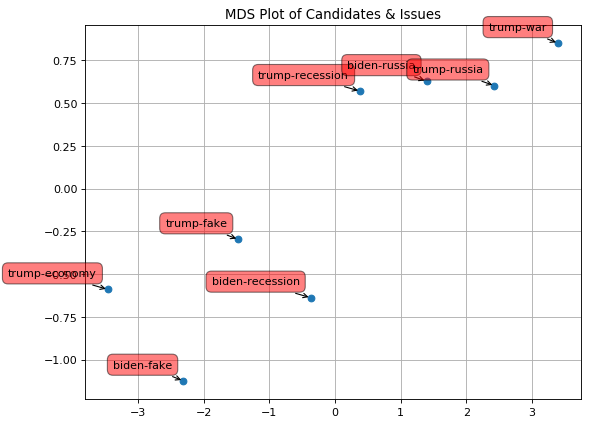

In [110]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(new_df.index, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        
plt.title('MDS Plot of Candidates & Issues')
plt.grid()
plt.show()

### E. Use the location data collected in step A to find out lifts and sentiments regarding the candidates in three states – Michigan, Pennsylvania and Wisconsin (no need to treat them separately, call them “battleground” states).

In [111]:
#Get all the cities with their respective battleground states
cities_states = pd.read_csv("https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv",sep='|')

battleground_set = {'Pennsylvania', 'Michigan', 'Wisconsin'}
battleground_mask = cities_states['State full'].isin(battleground_set)

battleground_set.update(set(cities_states[battleground_mask]['City'].map(lambda v: v.lower()).tolist()))
battleground_short_set = set(cities_states[battleground_mask]['State short'].tolist())

In [112]:
import nltk
df_cleanlocation = df.dropna(subset=['User Location'])
battleground1_words = ['pennsylvania', 'PENNSYLVANIA', 'PA', 'Pennsylvania', 'Wisconsin',
                   'WISCONSIN', 'WI', 'wisconsin', 'michigan', 'MICHIGAN', 'Michigan', 'MI']

def convert_battleground(text):
    return [('battleground1' if word in battleground1_words else word) 
            for word in nltk.word_tokenize(text)]

df_cleanlocation['Split User Location'] = df_cleanlocation['User Location'].map(convert_battleground)
df_cleanlocation
i=0
battleid = []
for x in df_cleanlocation['Split User Location'].map(lambda x: x if 'battleground1'in x else False):
    if x !=False:
        battleid.append(i)
#         print(x)
    i+=1
df_battle = df_cleanlocation.iloc[battleid,:]
df_battle.head()

/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,Username,User Location,Tweet,Split Tweet,Split User Location
5,2019-08-31 22:49:37+00:00,nanychief,"Michigan, USA",THIS IS COMPLETE BS! WAITING UNTIL 2020 ELECTI...,"[this, is, complete, b, waiting, until, 2020, ...","[battleground1, ,, USA]"
137,2019-08-31 03:35:57+00:00,ltclavinny,"Wisconsin, USA",Stopping you from seeing the wisdom of great P...,"[stopping, you, from, seeing, the, wisdom, of,...","[battleground1, ,, USA]"
146,2019-08-31 02:00:20+00:00,rogerlsmith,"Grand Rapids, Michigan",The #MAGA president knows he's about to lose t...,"[the, trump, president, know, he's, about, to,...","[Grand, Rapids, ,, battleground1]"
153,2019-08-31 00:23:41+00:00,DESciulli,"Pennsylvania, USA",Step 1: Steal 2016 election Step 2: Consolidat...,"[step, 1, steal, 2016, election, step, 2, cons...","[battleground1, ,, USA]"
290,2019-08-30 10:34:26+00:00,Marine_Airwing,"Michigan, USA",Democratic contenders for the 2020 presidentia...,"[democratic, contender, for, the, 2020, presid...","[battleground1, ,, USA]"


In [113]:
df_cleanlocation['Combined'] = df_cleanlocation['Split Tweet'] + df_cleanlocation['Split User Location']
from itertools import combinations, product
# Calculation of lift scores
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = df_cleanlocation['Combined'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df
print('The lift values are')
do_lift(['battleground1'], ['trump', 'warren', 'biden'])

The lift values are


/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,biden,trump,warren
battleground1,0.691118,0.882354,0.678993


In [114]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

df_battle['Score'] = df_battle['Tweet'].map(lambda x: sentiment_analyzer_scores(x))

trump = 0
warren = 0
biden = 0
trump_list = []
warren_list = []
biden_list = []
for _,Info in df_battle.iterrows():
    if 'trump' in Info['Split Tweet']:
        trump += Info['Score']
        trump_list.append(Info['Score'])
    if 'warren' in Info['Split Tweet']:
        warren += Info['Score']
        warren_list.append(Info['Score'])
    if 'biden' in Info['Split Tweet']:
        biden += Info['Score']
        biden_list.append(Info['Score'])
print('Sentiment Score is')
print('trump = '+str(trump))
print('warren = '+str(warren))
print('biden = '+str(biden))

Sentiment Score is
trump = -1.9417
warren = 0.8016
biden = 1.3518999999999999


/Users/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
def get_proportion(ls):
    positive = 0
    for score in ls:
        if score >0:
            positive += 1
    return positive/len(ls)*100

print('Proportion of positive sentiment')
print('%s  of the tweet of Trump are positive.' %(str(round(get_proportion(trump_list),2))+'%'))
print('%s  of the tweet of Warren are positive.' %(str(round(get_proportion(warren_list),2))+'%'))
print('%s  of the tweet of Biden are positive.' %(str(round(get_proportion(biden_list),2))+'%'))

Proportion of positive sentiment
35.48%  of the tweet of Trump are positive.
100.0%  of the tweet of Warren are positive.
100.0%  of the tweet of Biden are positive.


### F.   What advice would you give to each of the two candidates above based on your analyses in C, D and E above?